## Import required libraries

In [78]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import pickle

## Read data

In [2]:
data_path = (
    Path.cwd().parent.parent.parent  # Repository root
    / "data"
    / "weather"
    / "open_meteo.csv"
)
df = pd.read_csv(data_path)
df.head()

,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city
0,2010-01-01,1,30.3,17.2,23.5,31.5,17.7,23.9,2010-01-01T00:04,2010-01-01T11:13,...,0.0,9.3,18.7,316,4.14,16.800003,96.20001,12.0,Myanmar,Yangoon
1,2010-01-02,1,30.9,16.8,23.6,30.6,16.6,23.4,2010-01-02T00:04,2010-01-02T11:13,...,0.0,12.8,27.7,342,4.77,16.800003,96.20001,12.0,Myanmar,Yangoon
2,2010-01-03,1,30.7,17.7,23.5,30.1,16.1,22.6,2010-01-03T00:05,2010-01-03T11:14,...,0.0,13.3,26.6,338,4.96,16.800003,96.20001,12.0,Myanmar,Yangoon
3,2010-01-04,3,30.8,17.6,24.2,30.7,16.8,24.2,2010-01-04T00:05,2010-01-04T11:14,...,0.0,12.1,25.6,327,4.57,16.800003,96.20001,12.0,Myanmar,Yangoon
4,2010-01-05,3,31.4,21.0,25.8,32.9,21.9,27.2,2010-01-05T00:05,2010-01-05T11:15,...,0.0,8.9,22.0,351,3.65,16.800003,96.20001,12.0,Myanmar,Yangoon


In [3]:
df.columns

Index(['time', 'weathercode', 'temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean', 'apparent_temperature_max',
       'apparent_temperature_min', 'apparent_temperature_mean', 'sunrise',
       'sunset', 'shortwave_radiation_sum', 'precipitation_sum', 'rain_sum',
       'snowfall_sum', 'precipitation_hours', 'windspeed_10m_max',
       'windgusts_10m_max', 'winddirection_10m_dominant',
       'et0_fao_evapotranspiration', 'latitude', 'longitude', 'elevation',
       'country', 'city'],
      dtype='object')

## check for null values

In [4]:
df.isnull().sum()

time                          0
weathercode                   0
temperature_2m_max            0
temperature_2m_min            0
temperature_2m_mean           0
apparent_temperature_max      0
apparent_temperature_min      0
apparent_temperature_mean     0
sunrise                       0
sunset                        0
shortwave_radiation_sum       0
precipitation_sum             0
rain_sum                      0
snowfall_sum                  0
precipitation_hours           0
windspeed_10m_max             0
windgusts_10m_max             0
winddirection_10m_dominant    0
et0_fao_evapotranspiration    1
latitude                      0
longitude                     0
elevation                     0
country                       0
city                          0
dtype: int64

In [5]:
df.describe()

,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,shortwave_radiation_sum,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation
count,49160.000000,49160.000000,49160.000000,49160.000000,49160.000000,49160.000000,49160.000000,49160.000000,49160.000000,49160.000000,49160.0,49160.000000,49160.000000,49160.000000,49160.000000,49159.000000,49160.000000,49160.000000,49160.000000
mean,33.857059,29.542915,20.791481,24.853009,33.169434,23.647325,27.976263,17.550412,5.536859,5.536859,0.0,6.172539,10.976257,29.554048,202.271562,3.802507,19.480003,96.770004,351.400000
std,28.346242,4.057097,4.564320,3.794812,5.265635,6.500045,5.357638,5.265606,10.746810,10.746810,0.0,7.791999,4.635709,8.671707,88.633301,1.379380,3.109951,2.017967,486.853635
min,0.000000,5.100000,3.500000,4.700000,2.700000,1.100000,2.200000,1.200000,0.000000,0.000000,0.0,0.000000,2.300000,9.000000,0.000000,0.350000,12.400002,92.399994,6.000000
25%,1.000000,27.100000,17.800000,22.500000,30.100000,19.200000,24.200000,14.550000,0.000000,0.000000,0.0,0.000000,7.600000,23.000000,152.000000,2.930000,16.900002,96.100006,12.000000
50%,51.000000,29.600000,22.000000,25.600000,33.800000,25.400000,29.500000,18.000000,0.500000,0.500000,0.0,2.000000,10.200000,28.400000,199.000000,3.710000,20.500004,96.650008,83.000000
75%,61.000000,31.800000,24.400000,27.300000,37.000000,29.000000,32.000000,21.370000,6.900000,6.900000,0.0,11.000000,13.500000,34.900000,270.000000,4.650000,21.400002,98.600006,787.000000
max,65.000000,42.900000,30.700000,36.500000,46.300000,35.300000,38.800000,29.660000,193.100000,193.100000,0.0,24.000000,57.600000,116.300000,360.000000,10.070000,23.800003,99.700010,1407.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49160 entries, 0 to 49159
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   time                        49160 non-null  object 
 1   weathercode                 49160 non-null  int64  
 2   temperature_2m_max          49160 non-null  float64
 3   temperature_2m_min          49160 non-null  float64
 4   temperature_2m_mean         49160 non-null  float64
 5   apparent_temperature_max    49160 non-null  float64
 6   apparent_temperature_min    49160 non-null  float64
 7   apparent_temperature_mean   49160 non-null  float64
 8   sunrise                     49160 non-null  object 
 9   sunset                      49160 non-null  object 
 10  shortwave_radiation_sum     49160 non-null  float64
 11  precipitation_sum           49160 non-null  float64
 12  rain_sum                    49160 non-null  float64
 13  snowfall_sum                491

## Covert time to correct format

In [7]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49160 entries, 0 to 49159
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        49160 non-null  datetime64[ns]
 1   weathercode                 49160 non-null  int64         
 2   temperature_2m_max          49160 non-null  float64       
 3   temperature_2m_min          49160 non-null  float64       
 4   temperature_2m_mean         49160 non-null  float64       
 5   apparent_temperature_max    49160 non-null  float64       
 6   apparent_temperature_min    49160 non-null  float64       
 7   apparent_temperature_mean   49160 non-null  float64       
 8   sunrise                     49160 non-null  object        
 9   sunset                      49160 non-null  object        
 10  shortwave_radiation_sum     49160 non-null  float64       
 11  precipitation_sum           49160 non-null  float64   

## Plot max and min temperature

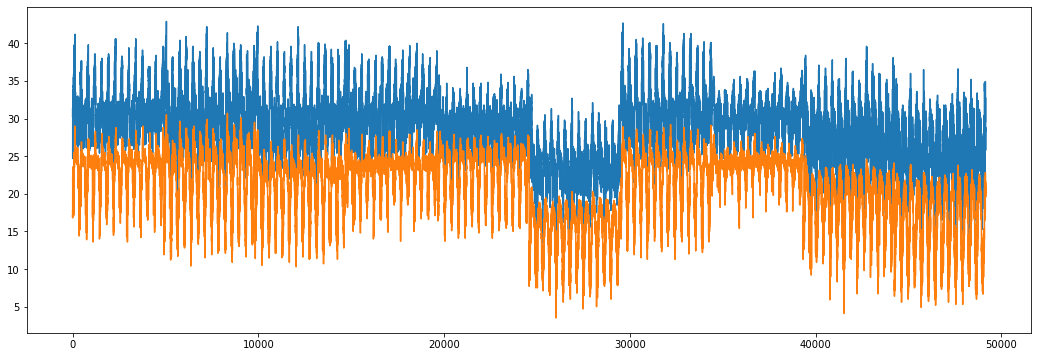

In [8]:
plt.figure(figsize=(18,6))
plt.plot(df["temperature_2m_max"], label="temp_max")
plt.plot(df["temperature_2m_min"], label="temp_min")

## Get temperature values from city

In [11]:
df['city'].value_counts()

Yangoon        4916
Mandalay       4916
Nay Pyi Taw    4916
Hpa-An         4916
Maungdaw       4916
Taunggyi       4916
Magway         4916
Myeik          4916
Keng Tung      4916
Laukkaing      4916
Name: city, dtype: int64

In [12]:
data = df[df['city'] == 'Yangoon']

In [13]:
data_max_temp = data[['time', 'temperature_2m_max']]
data_min_temp = data[['time', 'temperature_2m_min']]

## Rename columns 

In [14]:
data_max_temp = data_max_temp.rename(columns={'time': 'ds', 'temperature_2m_max': 'y'})
data_max_temp.head()

,ds,y
0,2010-01-01,30.3
1,2010-01-02,30.9
2,2010-01-03,30.7
3,2010-01-04,30.8
4,2010-01-05,31.4


In [15]:
data_min_temp = data_min_temp.rename(columns={'time': 'ds', 'temperature_2m_min': 'y'})
data_min_temp.head()

,ds,y
0,2010-01-01,17.2
1,2010-01-02,16.8
2,2010-01-03,17.7
3,2010-01-04,17.6
4,2010-01-05,21.0


## Plot Max temperature

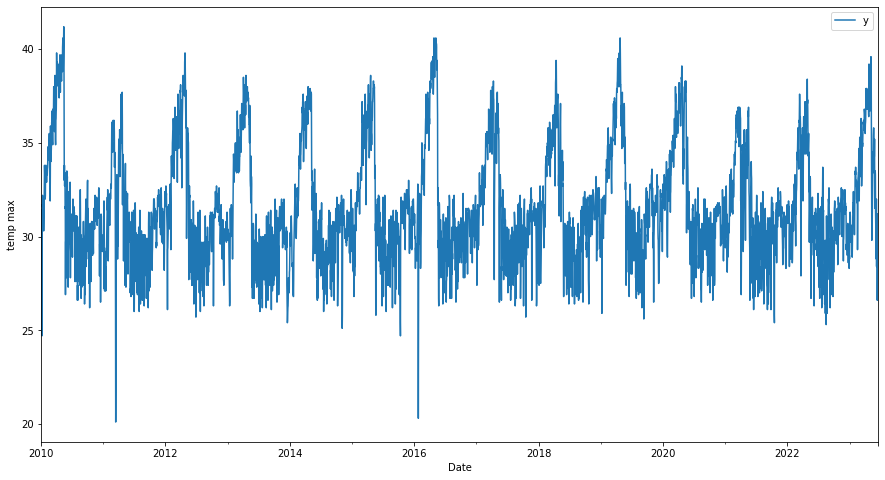

In [16]:
ax = data_max_temp.set_index('ds').plot(figsize=(15, 8))
ax.set_ylabel('temp max')
ax.set_xlabel('Date')
plt.show()

In [17]:
data_max_temp

,ds,y
0,2010-01-01,30.3
1,2010-01-02,30.9
2,2010-01-03,30.7
3,2010-01-04,30.8
4,2010-01-05,31.4
...,...,...
4911,2023-06-13,26.6
4912,2023-06-14,28.4
4913,2023-06-15,29.8
4914,2023-06-16,31.2


In [19]:
data_min_temp

,ds,y
0,2010-01-01,17.2
1,2010-01-02,16.8
2,2010-01-03,17.7
3,2010-01-04,17.6
4,2010-01-05,21.0
...,...,...
4911,2023-06-13,25.3
4912,2023-06-14,25.4
4913,2023-06-15,25.3
4914,2023-06-16,25.2


## train test split

In [18]:
def train_test_split(df):
    train_size = int(len(df) * 0.70)
    train, test = df[0:train_size], df[train_size:len(df)]
    return train, test

In [23]:
train_max_temp, test_max_temp = train_test_split(data_max_temp)

In [20]:
train_min_temp, test_min_temp = train_test_split(data_min_temp)

In [21]:
train_min_temp

,ds,y
0,2010-01-01,17.2
1,2010-01-02,16.8
2,2010-01-03,17.7
3,2010-01-04,17.6
4,2010-01-05,21.0
...,...,...
3436,2019-05-30,24.8
3437,2019-05-31,24.9
3438,2019-06-01,25.7
3439,2019-06-02,25.6


In [24]:
train_max_temp

,ds,y
0,2010-01-01,30.3
1,2010-01-02,30.9
2,2010-01-03,30.7
3,2010-01-04,30.8
4,2010-01-05,31.4
...,...,...
3436,2019-05-30,27.4
3437,2019-05-31,30.6
3438,2019-06-01,31.1
3439,2019-06-02,28.1


In [25]:
test_max_temp

,ds,y
3441,2019-06-04,31.0
3442,2019-06-05,29.9
3443,2019-06-06,30.2
3444,2019-06-07,31.9
3445,2019-06-08,30.9
...,...,...
4911,2023-06-13,26.6
4912,2023-06-14,28.4
4913,2023-06-15,29.8
4914,2023-06-16,31.2


In [26]:
test_min_temp

,ds,y
3441,2019-06-04,25.6
3442,2019-06-05,25.2
3443,2019-06-06,25.2
3444,2019-06-07,25.7
3445,2019-06-08,25.7
...,...,...
4911,2023-06-13,25.3
4912,2023-06-14,25.4
4913,2023-06-15,25.3
4914,2023-06-16,25.2


## Create Prophet Model

In [34]:
def prophet_model(train, test):
    model = Prophet(interval_width=0.95)
    model.fit(train)
    future = model.make_future_dataframe(periods=test.shape[0])
    return future, model

In [35]:
future_max, model_max = prophet_model(train_max_temp, test_max_temp)

17:35:02 - cmdstanpy - INFO - Chain [1] start processing
17:35:03 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
future_min, model_min = prophet_model(train_min_temp, test_min_temp)

17:35:03 - cmdstanpy - INFO - Chain [1] start processing
17:35:04 - cmdstanpy - INFO - Chain [1] done processing


## Forecast temperature

In [37]:
def forecast_temp(future, model):
    forecast = model.predict(future)
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    return forecast

### Forecast max temperature

In [38]:
forecast_max = forecast_temp(future_max, model_max)

In [41]:
forecast_max.head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-01,31.794197,28.794876,34.556499
1,2010-01-02,31.800965,28.477026,34.673903
2,2010-01-03,31.724002,28.763206,34.759358
3,2010-01-04,31.738022,28.611741,34.895194
4,2010-01-05,31.648765,28.735305,34.792747


### Forecast min temperature

In [39]:
forecast_min = forecast_temp(future_min, model_min)

In [42]:
forecast_min.head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-01,19.989655,17.620048,22.458101
1,2010-01-02,19.982646,17.452084,22.410221
2,2010-01-03,19.998442,17.547749,22.386868
3,2010-01-04,19.997974,17.437308,22.458573
4,2010-01-05,19.886047,17.585338,22.354949


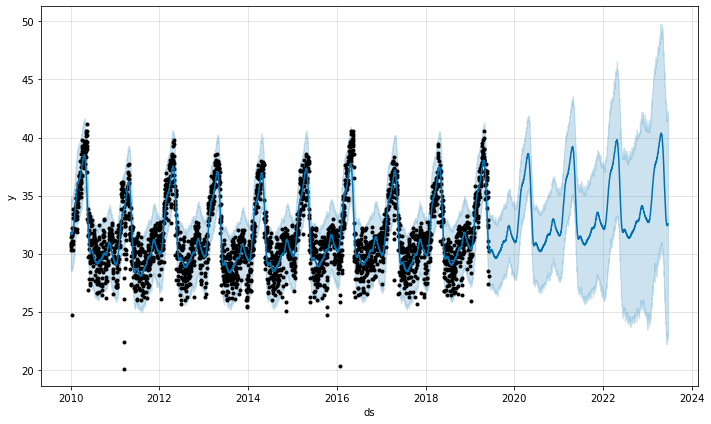

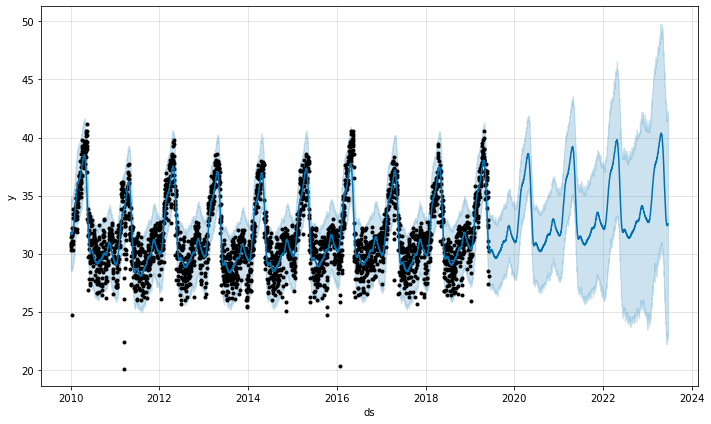

In [40]:
model_max.plot(forecast_max, uncertainty=True)

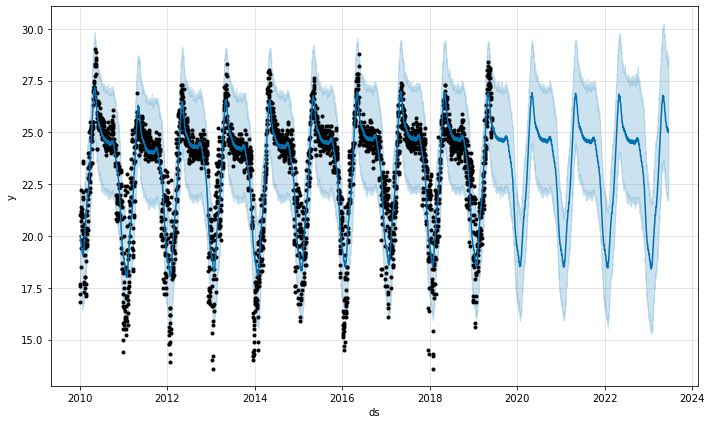

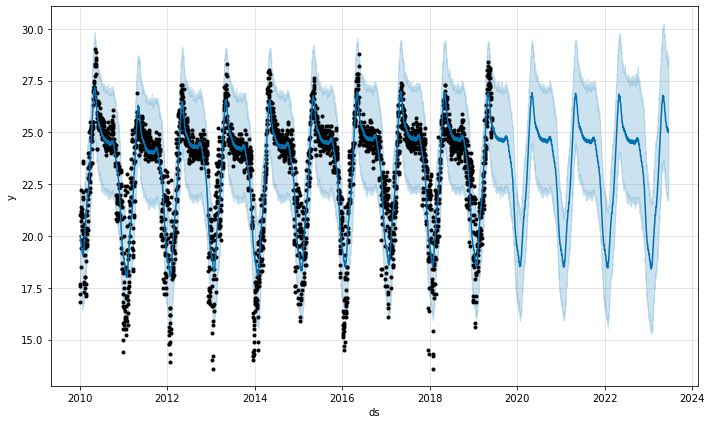

In [43]:
model_min.plot(forecast_min, uncertainty=True)

## Compare real and forecasted data

In [50]:
# 'y' is real temperature and 'yhat' is forecasted temperature
df_forecast_max = forecast_max[3441:]
df_forecast_max['y'] = test_max_temp['y']
df_forecast_max = df_forecast_max.filter(['ds','y','yhat'])
df_forecast_max

C:\Users\aayus\AppData\Local\Temp/ipykernel_18788/3687684419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecast_max['y'] = test_max_temp['y']


,ds,y,yhat
3441,2019-06-04,31.0,30.363583
3442,2019-06-05,29.9,30.288530
3443,2019-06-06,30.2,30.235158
3444,2019-06-07,31.9,30.243301
3445,2019-06-08,30.9,30.234348
...,...,...,...
4911,2023-06-13,26.6,32.399371
4912,2023-06-14,28.4,32.413915
4913,2023-06-15,29.8,32.439657
4914,2023-06-16,31.2,32.516118


In [51]:
df_forecast_min = forecast_min[3441:]
df_forecast_min['y'] = test_min_temp['y']
df_forecast_min = df_forecast_min.filter(['ds','y','yhat'])
df_forecast_min

C:\Users\aayus\AppData\Local\Temp/ipykernel_18788/2002809687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecast_min['y'] = test_min_temp['y']


,ds,y,yhat
3441,2019-06-04,25.6,25.350248
3442,2019-06-05,25.2,25.281853
3443,2019-06-06,25.2,25.245029
3444,2019-06-07,25.7,25.256522
3445,2019-06-08,25.7,25.268673
...,...,...,...
4911,2023-06-13,25.3,25.088284
4912,2023-06-14,25.4,25.027334
4913,2023-06-15,25.3,24.995150
4914,2023-06-16,25.2,25.008722


## Model Evaluation 

In [53]:
def model_evaluation(df_forecast):
    rmse = lambda act, pred: np.sqrt(mean_squared_error(act, pred))
    print(f'RMSE: {rmse(df_forecast["y"], df_forecast["yhat"])}')
    print(f'MAPE: {mean_absolute_percentage_error(df_forecast["y"], df_forecast["yhat"])}')

### Max temperature model evaluation

In [70]:
model_evaluation(df_forecast_max)

RMSE: 2.6183493713862447
MAPE: 0.06818346996326687


### Min temperature model evaluation

In [71]:
model_evaluation(df_forecast_min)

RMSE: 1.2046561692939735
MAPE: 0.039553801725418614


## Save Model

In [79]:
with open('Max_temperature_forecast.pkl', 'wb') as f:
    pickle.dump(model_max, f)

In [80]:
with open('Min_temperature_forecast.pkl', 'wb') as f:
    pickle.dump(model_min, f)